In [81]:
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
from scipy import sparse 
import sys
from gaussiandata import SyntheticTarget
import math
import scipy

import matplotlib.pyplot as matlab
%matplotlib inline

In [82]:
SEED = 666
number_of_gaussians = 2
ex = SyntheticTarget(seed=SEED, dist_components=number_of_gaussians)

N = 10000
M = 200
data = ex.draw_sample(N)
gamma = 0.029
kernel_matrix = rbf_kernel(data, gamma = gamma)

In [83]:
# K is the kernel matrix which is nbyn, n being the number of data points
# candidate indicies is an array of 0 to n-1, you might want to use a subset instead. TO CONSIDER.

def greedy_select_protos(K, candidate_indices, m, is_K_sparse=False):

    if len(candidate_indices) != np.shape(K)[0]:
        K = K[:,candidate_indices][candidate_indices,:]

    n = len(candidate_indices)

    # colsum = np.array(K.sum(0)).ravel() # same as rowsum
    if is_K_sparse:
        colsum = 2*np.array(K.sum(0)).ravel() / n
    else:
        colsum = 2*np.sum(K, axis=0) / n

    selected = np.array([], dtype=int)
    value = np.array([])
    for i in range(m):
        maxx = -sys.float_info.max
        argmax = -1
        candidates = np.setdiff1d(range(n), selected)

        s1array = colsum[candidates]
        if len(selected) > 0:
            temp = K[selected, :][:, candidates]
            if is_K_sparse:
                # s2array = temp.sum(0) *2
                s2array = temp.sum(0) * 2 + K.diagonal()[candidates]

            else:
                s2array = np.sum(temp, axis=0) *2 + np.diagonal(K)[candidates]

            s2array = s2array/(len(selected) + 1)

            s1array = s1array - s2array

        else:
            if is_K_sparse:
                s1array = s1array - np.log(np.abs(K.diagonal()[candidates]))
            else:
                s1array = s1array - np.log(np.abs(np.diagonal(K)[candidates]))

        argmax = candidates[np.argmax(s1array)]
        # print "max %f" %np.max(s1array)

        selected = np.append(selected, argmax)
        # value = np.append(value,maxx)
        KK = K[selected, :][:, selected]
        if is_K_sparse:
            KK = KK.todense()

        inverse_of_prev_selected = np.linalg.inv(KK)  # shortcut

    return candidate_indices[selected]

In [84]:
#print np.array(range(np.shape(kernel_matrix)[0]))
#print np.array(range(N))
prototype_indices = greedy_select_protos(kernel_matrix, candidate_indices = np.array(range(N)), m = M)

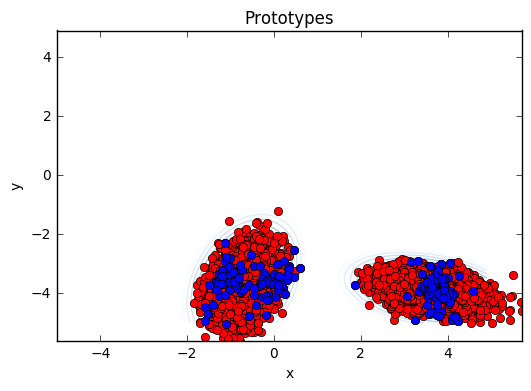

In [85]:
ex.plot()
matlab.plot(data[:N,0], data[:N,1], 'ro');
matlab.plot(data[prototype_indices,0], data[prototype_indices,1], 'bo');
matlab.xlabel('x')
matlab.ylabel('y')
matlab.title('Prototypes')

In [86]:
##############################################################################################################################
# function to select criticisms
# K is the kernel matrix which is nbyn, n being the number of data points
# selectedprotos: prototypes already selected
# m : number of criticisms to be selected
# reg: regularizer type.
# is_K_sparse:  True means K is the pre-computed  csc sparse matrix? False means it is a dense matrix.
# RETURNS: indices selected as criticisms
##############################################################################################################################
def greedy_select_criticism_regularized(K, selectedprotos, m, reg='logdet', is_K_sparse=False):

    n = np.shape(K)[0]
    if reg in ['None','logdet','iterative']:
        pass
    else:
        print "wrong regularizer :" + regularizer
        exit(1)
    options = dict()

    selected = np.array([], dtype=int)
    candidates2 = np.setdiff1d(range(n), selectedprotos)
    inverse_of_prev_selected = None  # should be a matrix

    if is_K_sparse:
        colsum = np.array(K.sum(0)).ravel()/n
    else:
        colsum = np.sum(K, axis=0)/n

    for i in range(m):
        maxx = -sys.float_info.max
        argmax = -1
        candidates = np.setdiff1d(candidates2, selected)

        s1array = colsum[candidates]

        temp = K[selectedprotos, :][:, candidates]
        if is_K_sparse:
            s2array = temp.sum(0)
        else:
            s2array = np.sum(temp, axis=0)

        s2array = s2array / (len(selectedprotos))

        s1array = np.abs(s1array - s2array)
        if reg == 'logdet':
            if inverse_of_prev_selected is not None: # first call has been made already
                temp = K[selected, :][:, candidates]
                if is_K_sparse:
                    temp2 = temp.transpose().dot(inverse_of_prev_selected)
                    regularizer = temp.transpose().multiply(temp2)
                    regcolsum = regularizer.sum(1).ravel()# np.sum(regularizer, axis=0)
                    regularizer = np.abs(K.diagonal()[candidates] - regcolsum)

                else:
                    # hadamard product
                    temp2 = np.array(np.dot(inverse_of_prev_selected, temp))
                    regularizer = temp2 * temp
                    regcolsum = np.sum(regularizer, axis=0)
                    regularizer = np.log(np.abs(np.diagonal(K)[candidates] - regcolsum))
                s1array = s1array + regularizer
            else:
                if is_K_sparse:
                    s1array = s1array - np.log(np.abs(K.diagonal()[candidates]))
                else:
                    s1array = s1array - np.log(np.abs(np.diagonal(K)[candidates]))
        argmax = candidates[np.argmax(s1array)]
        maxx = np.max(s1array)

        selected = np.append(selected, argmax)
        if reg == 'logdet':
            KK = K[selected,:][:,selected]
            if is_K_sparse:
                KK = KK.todense()

            inverse_of_prev_selected = np.linalg.inv(KK) # shortcut
        if reg == 'iterative':
            selectedprotos = np.append(selectedprotos, argmax)

    return selected


In [87]:
#included argument is_K_sparse = False since otherwise todense function is not recognized. CHECK.
criticism_indices = greedy_select_criticism_regularized(kernel_matrix, selectedprotos = prototype_indices, m = M,  reg = 'None', is_K_sparse=False)

#K_sparse = sparse.csr_matrix(kernel_matrix)
#criticism_indices_sparse = greedy_select_criticism_regularized(K_sparse, selectedprotos = prototype_indices, m = M/4,  is_K_sparse=True)

In [88]:
print criticism_indices

[1489 2872 5779 5284 1749 3334 9635 6058 5040 4932 5917 9394 3875 9879 7019
 5683 6636 4112 2779 2954 9225 8664 9551 8890 2266  258   29 4833 6587 3128
  440 5656 8511 8226 1423 3114 1212 8460 7849 5994 4805 6934  331 9382 3282
 4566 2433 4198 1279  330 9353   78 7540 4822 2118  584 8081  786 2615 5022
 8814 9741 9479  697 1735 9585 6168 6028 1934 3465 3609 6716 9403 5579 7333
 1368 4010 1418 9415 7160 4392 9824 2492 3884 5432  979 1285 8563 4727 9906
 5178 8205 6999 3012 6364 1369 9713 1173  459 1404 4549 1415 7156 6240 4951
 1321 6771 4893 3219 4662 3356 8742 7733 8111 6566 3596 5043 7839 3763 6922
 1018 3250  257 4877 2824 4066  248  396 7956 8755 8696 2413 1308 9676 8351
 9840 9381  594 4183 1774 6122  402 4808 3048 5841 7015 9546 5363  239 1598
 1132  776 6745 3730 1898 9012 3788  410 5329 8362 9406 3363 6746 3238 3214
 9109 3984 7868 3639  179 4012 1225 9039 4507 8327 8545 5561 9341 6321 1244
 7521 2068 8464 2002 6151 1205 5029 6469 6902 2052 9085  587 5195 6637 8408
 4421 2645 2

[-6, 6, -6, 2]

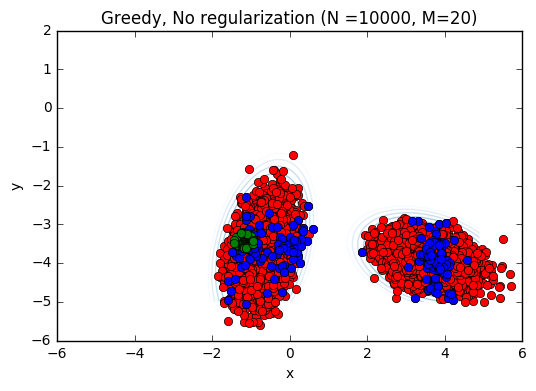

In [89]:
ex.plot()
matlab.plot(data[:N,0], data[:N,1], 'ro');
matlab.plot(data[prototype_indices,0], data[prototype_indices,1], 'bo');
matlab.plot(data[criticism_indices,0], data[criticism_indices,1], 'go');
matlab.xlabel('x')
matlab.ylabel('y')
matlab.title('Greedy, No regularization (N =10000, M=20)')
matlab.axis([-6, 6, -6, 2])

In [90]:
criticism_indices2 = greedy_select_criticism_regularized(kernel_matrix, selectedprotos = prototype_indices, m = M/5,  reg = 'logdet', is_K_sparse=False)

In [91]:
print prototype_indices

[1036 6247 5218 7210 3486 2058 6624 4022  702 8797 8761 1436 5926 2798  845
 5873 6762 5971 3468  151 7809 4244 1756 8867 4682 3859 8917 9656 2537 4766
 1297 4787 8058 5136 4711 1447 5825 7949 5912 5130 7102  231 8358 1454 6395
 8252 7816 8490 6632 4286 6133 6740 9352 4545 1356 2008 9555 8552 7168 6064
 5839 2685 1417 2769 5160 6741 6237 7758 6335 8127 7398 4993 8293 8198 4482
 1629 8274 3326 8204 6871 8169 3743 4804 5235 5087 6550 6105 2060 1597 3757
  378 5335  844 7734 6963 5650 9041 8491 7800 9099 7760  956 9940 3387 6080
 3207 5759 4409 5767 1813 2399 6611 6543 8915 7805 3089 8302 3498  504 8418
 4693  453 9946 6097  771 2814  733 4616 1073 2755  174 9772 7794 8258  277
   40 8103 8653 7308 1770 5382 4745 1970 1994 1004 1554 1604 3280 2175 5272
 9961 1951  675 5567 2428 7026 4944 1858 7779 7645 9784 9431 7427 5306  814
 7936  586 3217 6540 6049 7216 2233 7150 5244 9957  321 1373 1910  367 6816
 6219 2959  686  694 4342 9885  140 7206 9639 5723 9513 1838 4248 6687 2812
 1580 8594 6

[-3, 6, -6, 0]

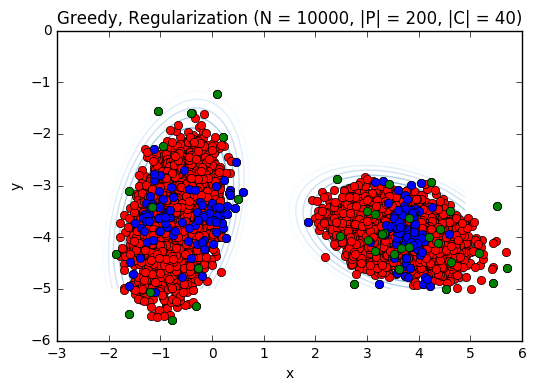

In [92]:
ex.plot()
matlab.plot(data[:N,0], data[:N,1], 'ro');
matlab.plot(data[prototype_indices,0], data[prototype_indices,1], 'bo');
matlab.plot(data[criticism_indices2,0], data[criticism_indices2,1], 'go');
matlab.xlabel('x')
matlab.ylabel('y')
matlab.title('Greedy, Regularization (N = 10000, |P| = 200, |C| = 40)')
matlab.axis([-3, 6, -6, 0])

In [93]:
# Change for different sampled target dist
SEED = 666
ex = SyntheticTarget(seed=SEED, dist_components=2)
N = 1000
M = 10
stream = ex.draw_sample(N)
#stream.shape finds the dimensions of the nparray stream
print stream.shape, "=>", M

(1000, 2) => 10
